# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **
This type of supervised learning problem is classification. The reason is that we are trying to "classify" students into discrete categories - those who need early intervention before failing to graduate, and those that do not. In the case of regression, prediction is used to determine a continuous value such as time, money, or any non-discrete type value. 

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [3]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [4]:
# TODO: Calculate number of students
#n_students = student_data.sum('n_students')
n_students = len(student_data.index)

# TODO: Calculate number of features
n_features = (len(student_data.count(axis=0, level=None, numeric_only=False)))-1


# TODO: Calculate passing students
n_passed = len(student_data[student_data.passed == 'yes'])

# TODO: Calculate failing students
n_failed = len(student_data[student_data.passed == 'no'])

# TODO: Calculate graduation rate
grad_rate = ((len(student_data[student_data.passed == 'yes']))/float(n_students))*100

# Calculate F1 score for predicting all "yes" values
from sklearn.metrics import f1_score

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

print "\nF1 score for predicting all 'yes': {:.4f}".format(
    f1_score(y_true = ['yes']*n_passed + ['no']*n_failed, y_pred = ['yes']*n_students, pos_label='yes', average='binary'))

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%

F1 score for predicting all 'yes': 0.8030


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

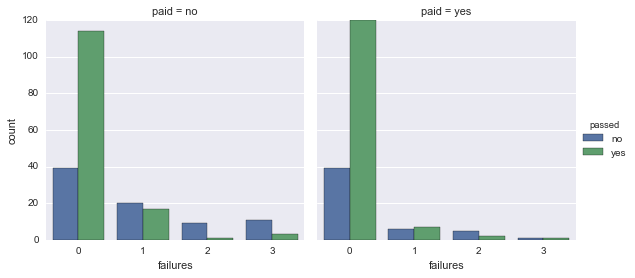

In [5]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

%matplotlib inline

import seaborn as sns
sns.factorplot("failures", col="paid", data=student_data, hue='passed', kind="count")

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [6]:

def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))


Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [7]:
# TODO: Import any additional functionality you may need here
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, ShuffleSplit

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train


# TODO: Shuffle and split the dataset into the number of training and testing points above
def shuffle_split_data(X, y):
#     X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25, random_state=0) 
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify=y_all, test_size=0.24, random_state=42)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = shuffle_split_data(X_all,y_all)


# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])


print "\nGrad rate of train set: {:.2f}%".format(100 * (y_train == 'yes').mean())
print "Grad rate of test set: {:.2f}%".format(100 * (y_test == 'yes').mean())

Training set has 300 samples.
Testing set has 95 samples.

Grad rate of train set: 67.00%
Grad rate of test set: 67.37%


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **
1. Support Vector Machines (SVM)
    - SVM's have very broad uses, most notably with non-linear dependent/independent variable relationships. Can be used for discrete categories or continuous values, linear or non-linear kernels. This makes them useful for a large variety of industries, but according to a paper by Asa Ben-Hur and Jason Weston, a classic use case is in bioinformatics sequencing, which requires "no obvious fixed-dimensional vector space representation."
    http://pyml.sourceforge.net/doc/howto.pdf
    - Some of the downsides of using SVM's are their complexity, which makes them difficult to interpret. This also makes it difficult to choose the appropriate kernel to use to prevent things like overfitting. It also requires large amounts of training time and computational power.
    This is a good candidate for this data set because we are trying to categorize the data for our prediction. The data likely doesn't have a linear relationship and therefore the complex transformations used by SVM kernels followed by the complex computations.

2. Logistic Regression
    - Since we are looking to more or less divide the data into two groups, whether or not a student will graduate, a linearly separable line may be appropriate if the data is linearly separable. Additionally, it is relatively straight forward and simple to use and variance can be kept low to minimize overfitting. Also, data does not have to be normally distributed. One industry that uses this type of method is in the prediction of failure, particularly business failures:
    http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2171511
    - This type of model does not perform that well if there isn't a single decision boundary or one underlying cause. To be an effective predictor also requires a large amount of data. Also, if the correct variable isn’t used as predictors for the dependent variable, it will have little predictive value.
    - For the student data set, assuming be can identify variables that have the greatest influence on graduation rate, logistic regression may be a simple and highly scoring predictor that will divide or outcome variables into the two classes we are seeking.
3. Gaussian Naive Bayes (GaussianNB)
    - Naive Bayes is used for assess the risk of cancer relapse after radiotherapy:
    http://www.sciencedirect.com/science/article/pii/S0167814007005221
    - Some advantages of Naive Bayes classifiers have fast training speeds due to their simplicity, they perform well with smaller numbers of samples, quicker than regression, and can be used for classification. 
    - Some of the disadvantages are that they can't learn interactions between features - assumes conditional independence.  
    - For this models, Naive Bayes may be a great way quickly and simply model the smaller sized dataset in our classification problem.


### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [8]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [9]:
# TODO: Import the three supervised learning models from sklearn
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# TODO: Initialize the three models
clf_A = svm.SVC()
clf_B = LogisticRegression()
clf_C = GaussianNB()

# TODO: Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train[:300]
y_train_300 = y_train[:300]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
for clf in [clf_A, clf_B, clf_C]:
    print "\n{}: \n".format(clf.__class__.__name__)
    for n in [100, 200, 300]:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
        print "\n"

# train_predict(clf_A, X_train_100, y_train_100, X_test, y_test)
# print "\n"

# train_predict(clf_B, X_train_100, y_train_100, X_test, y_test)
# print "\n"

# train_predict(clf_C, X_train_100, y_train_100, X_test, y_test)
# print "\n"

# print "------------------------------------------"
# print "\n"

# train_predict(clf_A, X_train_200, y_train_200, X_test, y_test)
# print "\n"

# train_predict(clf_B, X_train_200, y_train_200, X_test, y_test)
# print "\n"

# train_predict(clf_C, X_train_200, y_train_200, X_test, y_test)
# print "\n"

# print "------------------------------------------"
# print "\n"

# train_predict(clf_A, X_train_300, y_train_300, X_test, y_test)
# print "\n"

# train_predict(clf_B, X_train_300, y_train_300, X_test, y_test)
# print "\n"

# train_predict(clf_C, X_train_300, y_train_300, X_test, y_test)


SVC: 

Training a SVC using a training set size of 100. . .
Trained model in 0.0010 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.8354.
Made predictions in 0.0010 seconds.
F1 score for test set: 0.8025.


Training a SVC using a training set size of 200. . .
Trained model in 0.0040 seconds
Made predictions in 0.0020 seconds.
F1 score for training set: 0.8431.
Made predictions in 0.0010 seconds.
F1 score for test set: 0.8105.


Training a SVC using a training set size of 300. . .
Trained model in 0.0060 seconds
Made predictions in 0.0050 seconds.
F1 score for training set: 0.8664.
Made predictions in 0.0020 seconds.
F1 score for test set: 0.8052.



LogisticRegression: 

Training a LogisticRegression using a training set size of 100. . .
Trained model in 0.0010 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.8671.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.7068.


Training a LogisticRegression using a training set siz

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - SVC **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |    0.0010 s|0.0000 s|0.8354|0.8025|
| 200               |        0.0050 s|0.0020 s|0.8431|0.8105|
| 300               |              0.0080 s|0.0020 s|0.8664|    0.8052      |

** Classifer 2 - Logistic Regression **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |0.0010 s|0.0000 s|0.8000|0.7068|
| 200               |     0.0030 s              |0.0000 s|0.8269|0.7391|
| 300               |0.0040 s|0.0000 s|0.8474|     0.7500     |

** Classifer 3 - Gaussian Naive Bayes **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |0.0010 s|0.0000 s|0.7752|0.6457|
| 200               |0.0010 s|0.0000 s|0.8060|0.7218|
| 300               |0.0010 s|0.0000 s|0.8134|0.7761|

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **
It appears the SVM would be the best model to use. Although the training time is larger than the other models - nearly double the Logistic Regression and nine times the Naive Bayes - it has the highest F1 score for the training and testing set. It does appear that the Logistic Regression is improving with greater data and may be a better model if there is more, however based on our training size the SVM appears to be greater with our initial tests. With some modifications though one could prove to be superior. The Naive Bayes appears to continuing to converge to an even lower score, lower than both of the other models and therefore does not appear to be the best one to choose.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **
How Support Vector Machines (SVM's) works is they find the points in a dataset that are the more difficult ones to classify. This weights the data points differently, optimizing the algorithm in a way classifiers that weight all points the same can't do. This approach finds the best line and makes a prediction by separating the data by finding points in different classes that are closest together and making a line that is the maximum distance between them. 

The major qualities of SVM's is that they are extremely accurate and work really well that usually avoid problems of overfitting that happen with other models. Different kernels make them able to work well with data that isn't linearly separable.

With the current dataset, the SVM uses past student metrics, such as their work status, parental situation, age, gender, etc., and compares them to whether or not they graduated. Plotting these features against graduation rate will hopefully show a way for a boundary line to be drawn that not only separates them, but also with a line that maximizes the margin between data points with different graduation rates. An example is shown below:
![SVM](https://udacity-github-sync-content.s3.amazonaws.com/_imgs/19273/1468014011/optimal-hyperplane.png)

To better separate data, SVM's can convert the input space form 2-dimensional to 3-dimensional, creating a plane rather than a vector space, demonstrated below:
![SVM](https://udacity-github-sync-content.s3.amazonaws.com/_imgs/19273/1464624531/1gvce.png)
Having tested out different ways of doing this, the SVM will use this past student data compared with their graduation rates to predict the ability to predict future student graduation rates using the same features, with some measurable amount of confidence. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [10]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn import svm, grid_search, datasets
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import StratifiedShuffleSplit

cv = StratifiedShuffleSplit(y_train)

normer = Normalizer()
X_train = normer.fit_transform(X_train)
X_test = normer.transform(X_test)

from sklearn.metrics import fbeta_score, make_scorer
# TODO: Create the parameters list you wish to tune
parameters = [{'kernel':['linear'], 'gamma':[1000, 100, 10, 1, 0.5, 0.1, 0.01, 0.001, 0.0001], 
               'C':[0.001, 0.01, 0.05, 0.5, 1, 5, 10, 20, 30, 100, 1000],'random_state':[0, 42]}]
              
#              , {'kernel':['rbf'], 'gamma':[0.001, 0.0001], 
#               'C':[0.01, 0.5, 1, 10, 100, 1000]}, {'kernel':['sigmoid'], 
#               'C':[0.01, 0.5, 1, 10, 100, 1000]}, {'kernel':['poly'], 
#               'C':[0.01, 0.5, 1, 10, 100, 1000]}]
# , 'gamma':[0.001, 0.0001], 'random_state':[None,40]}

# TODO: Initialize the classifier
svr = svm.SVC()
# clf = grid_search.GridSearchCV(svr, param_grid=parameters)
# clf.fit(X_train, y_train)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = grid_search.GridSearchCV(svr, param_grid=parameters, scoring=f1_scorer, cv=cv)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

print "\nF1 score for predicting all \"yes\" on test set: {:.4f}".format(
    f1_score(y_test, ['yes']*len(y_test), pos_label='yes', average='binary'))

grid_obj.best_params_

Made predictions in 0.0020 seconds.
Tuned model has a training F1 score of 0.8288.
Made predictions in 0.0010 seconds.
Tuned model has a testing F1 score of 0.7919.

F1 score for predicting all "yes" on test set: 0.8050


{'C': 10, 'gamma': 0.01, 'kernel': 'linear', 'random_state': 42}

### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **

Revised:

My previous response is below. After making all of the reccomended changes and a few optional tips from my initial submission review, my results have changed. My F1 score is now less than my untuned score. Both scores changed after doing the things reccomended like normalizing the x_train and test, balancing the proportion of passes to fails. The new tuned score is higher than F1 for predicting all 'yes's.   

My final F1 score for the training was 0.8288 seconds.

My final F1 score for the testing was 0.7919 seconds.

The new untuned scores for training were 0.8664 and	0.8052 respectively. 

Original:

My final F1 score for the training was 0.8712 seconds.

My final F1 score for the testing was 0.7632 seconds.

This score is exactly the same as my untuned score. This was only after I went back and changed some of the parameters in my param_grid. Initially it was lower than the untuned model. Not knowing how this was possible I consulted the forums and learnt that I had to fit my data before getting a better parameter combination. I also adjusted the parameters I was using because it seemed to take way too long with the number I was using. In the end the best I could get was my untuned score with a training test size of 300. Any feedback on how to improve this to a better score would be extremely helpful. Thanks! 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.